# Comparison of the models
@LuiseJedlitschka @davmar01

We decided to train the following models: MLP, Random Forest, XGBoost.
We trained them on stratified 80/20 split and on leave-one-group-out splits (one dataset as testset each).
These trained models are being compared here in their accuracy using confusion matrices and metrics (precision, recall, f1).

In [32]:
import joblib
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from math import pi

# Suppress unnecessary warnings
import warnings
from sklearn.exceptions import InconsistentVersionWarning

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


In [33]:
# === Setup for MLP ===
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))
        return self.out(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

=== Split 0 ===


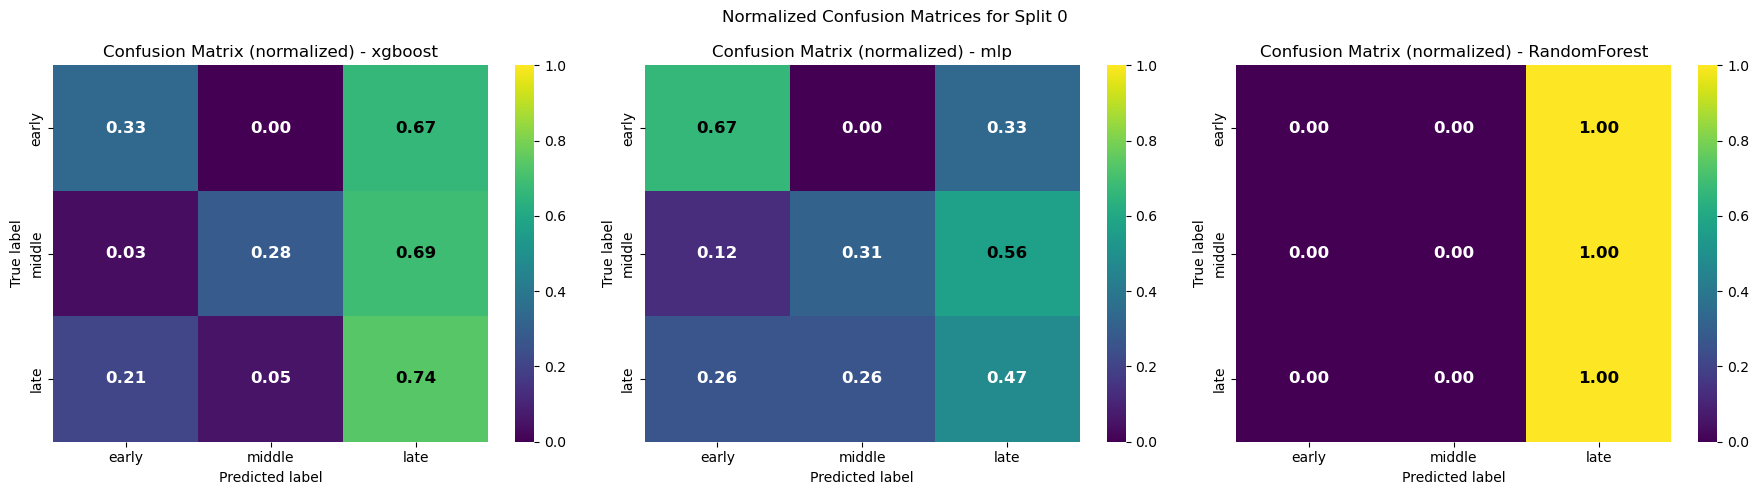

,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.672222,0.444444,0.439153
1,0,mlp,0.388889,0.518258,0.388889,0.402792
2,0,RandomForest,0.351852,0.123800,0.351852,0.183156


=== Split 1 ===


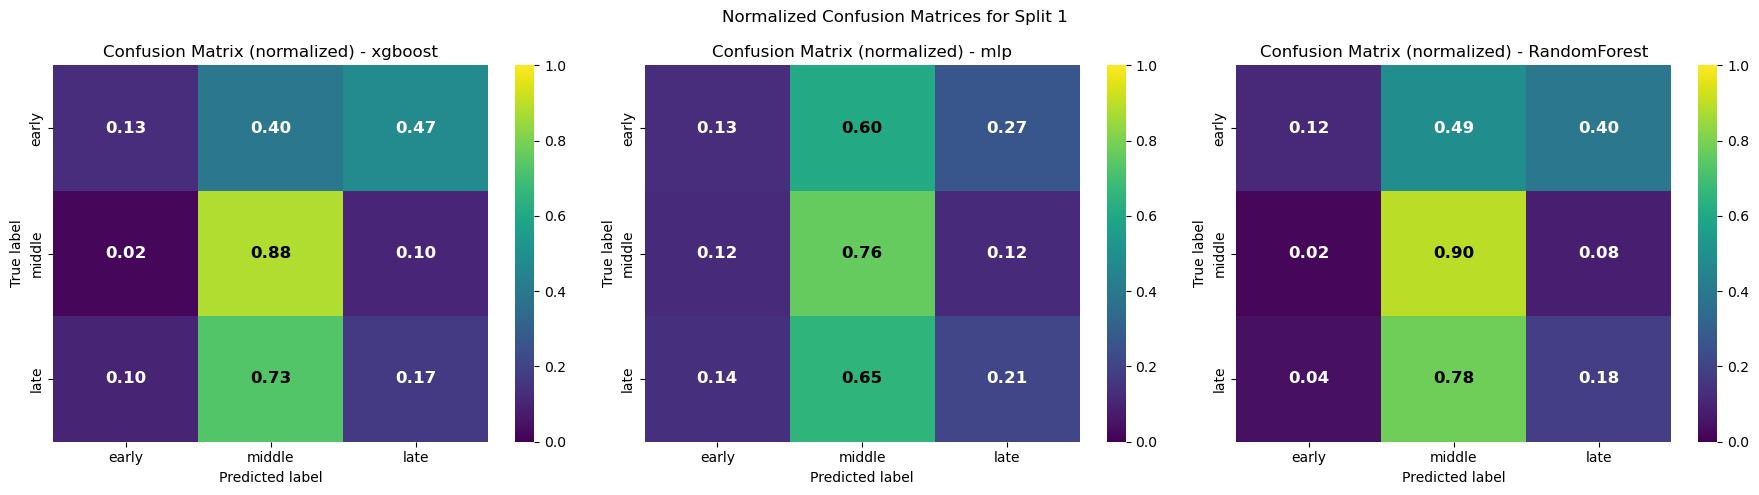

,Split,Model,Accuracy,Precision,Recall,F1
0,1,xgboost,0.333333,0.359253,0.333333,0.276570
1,1,mlp,0.320675,0.358351,0.320675,0.283051
2,1,RandomForest,0.337553,0.430292,0.337553,0.278765


=== Split 2 ===


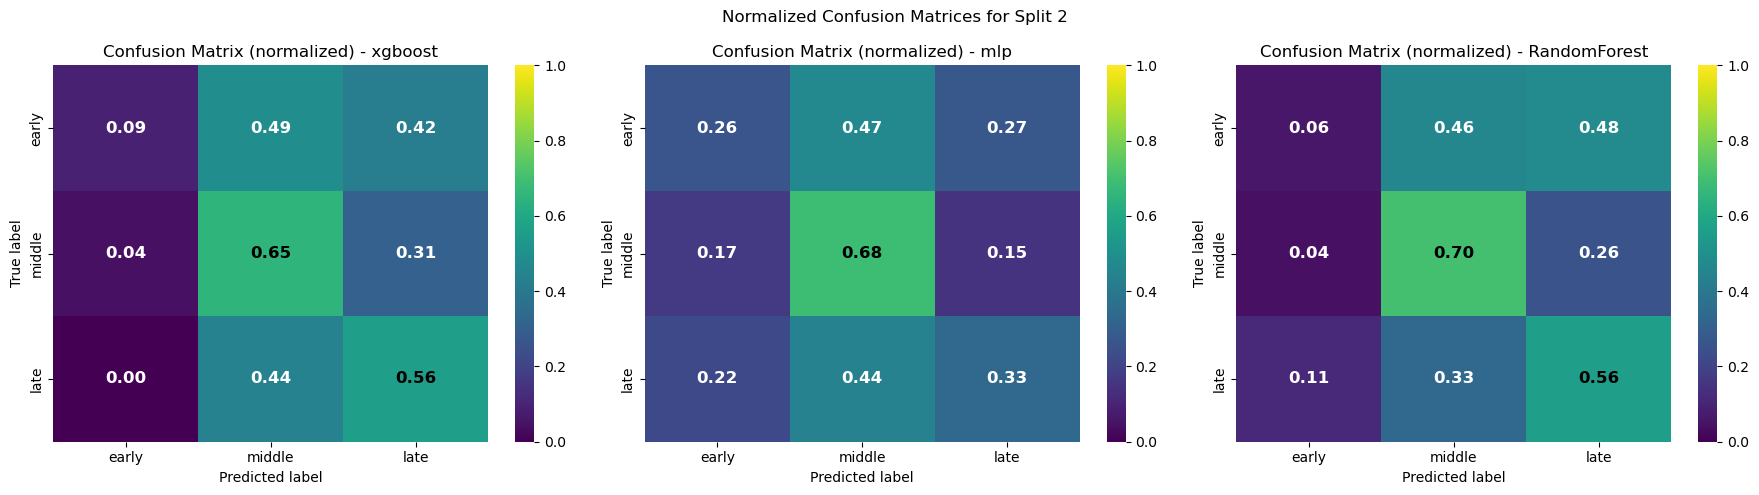

,Split,Model,Accuracy,Precision,Recall,F1
0,2,xgboost,0.333333,0.617491,0.333333,0.319100
1,2,mlp,0.434028,0.573730,0.434028,0.446296
2,2,RandomForest,0.336806,0.561161,0.336806,0.306308


=== Split 3 ===


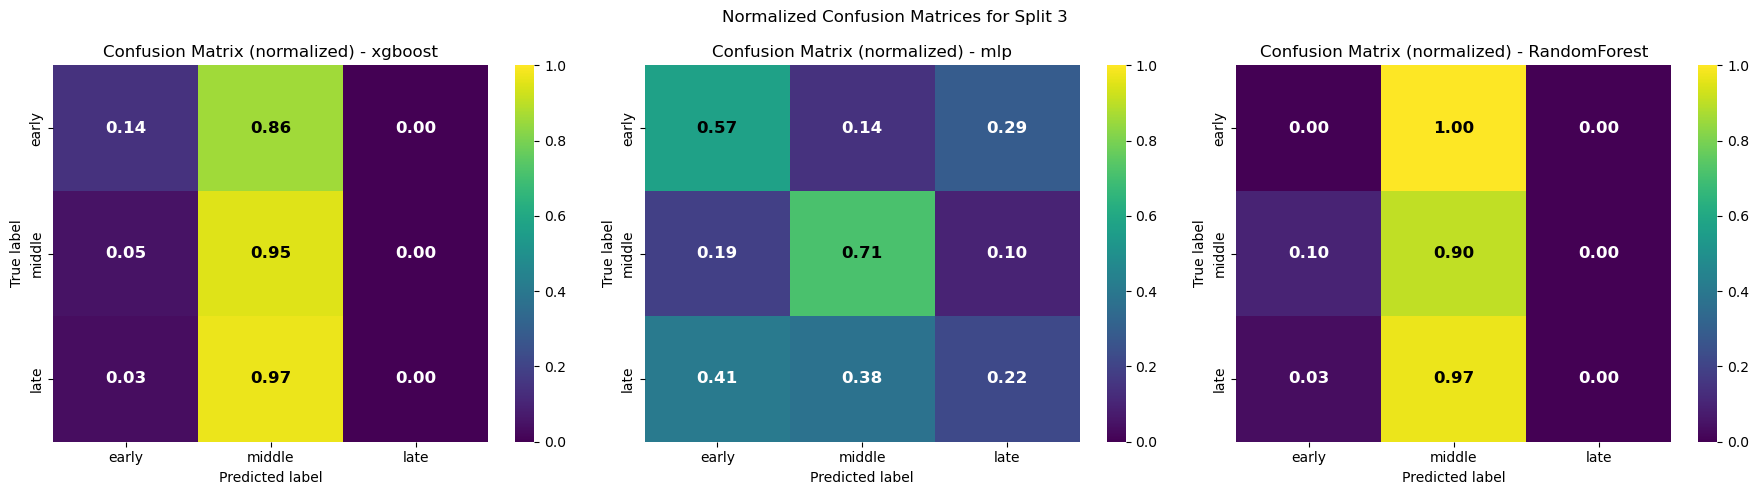

,Split,Model,Accuracy,Precision,Recall,F1
0,3,xgboost,0.350000,0.161696,0.350000,0.202821
1,3,mlp,0.433333,0.549116,0.433333,0.421262
2,3,RandomForest,0.316667,0.116667,0.316667,0.170513


=== Split 4 ===


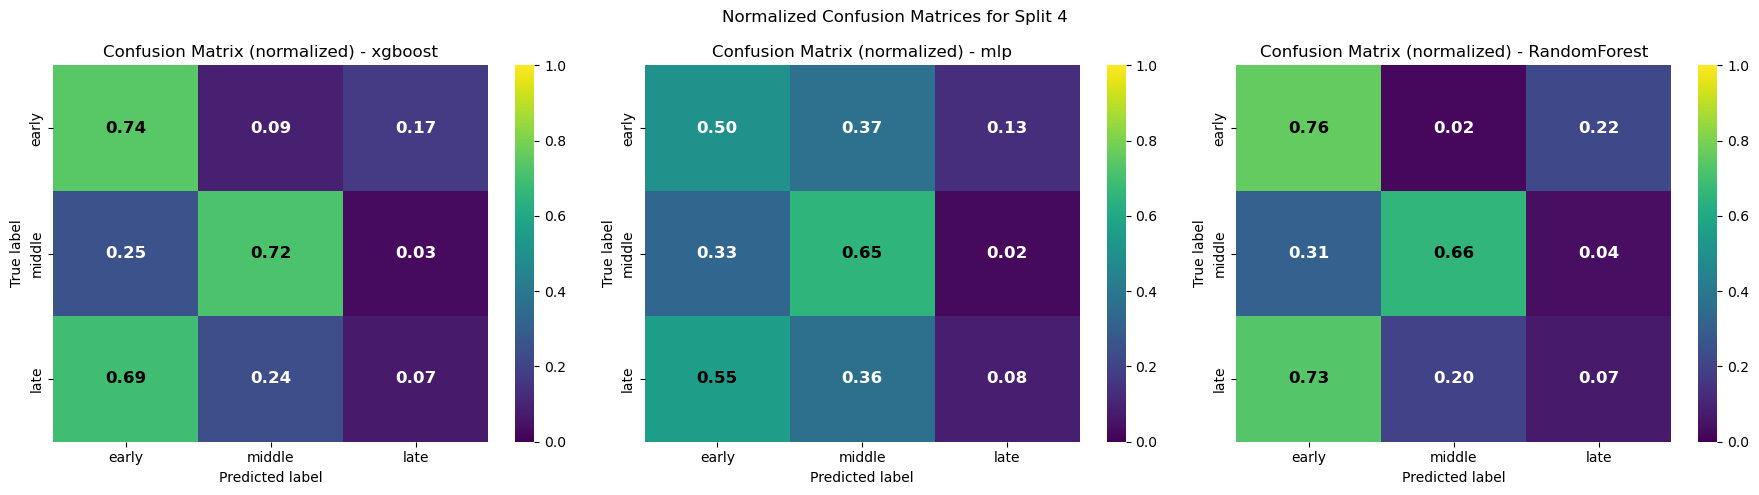

,Split,Model,Accuracy,Precision,Recall,F1
0,4,xgboost,0.429501,0.573175,0.429501,0.408172
1,4,mlp,0.381779,0.552926,0.381779,0.365399
2,4,RandomForest,0.403471,0.556455,0.403471,0.396326


=== Split 5 ===


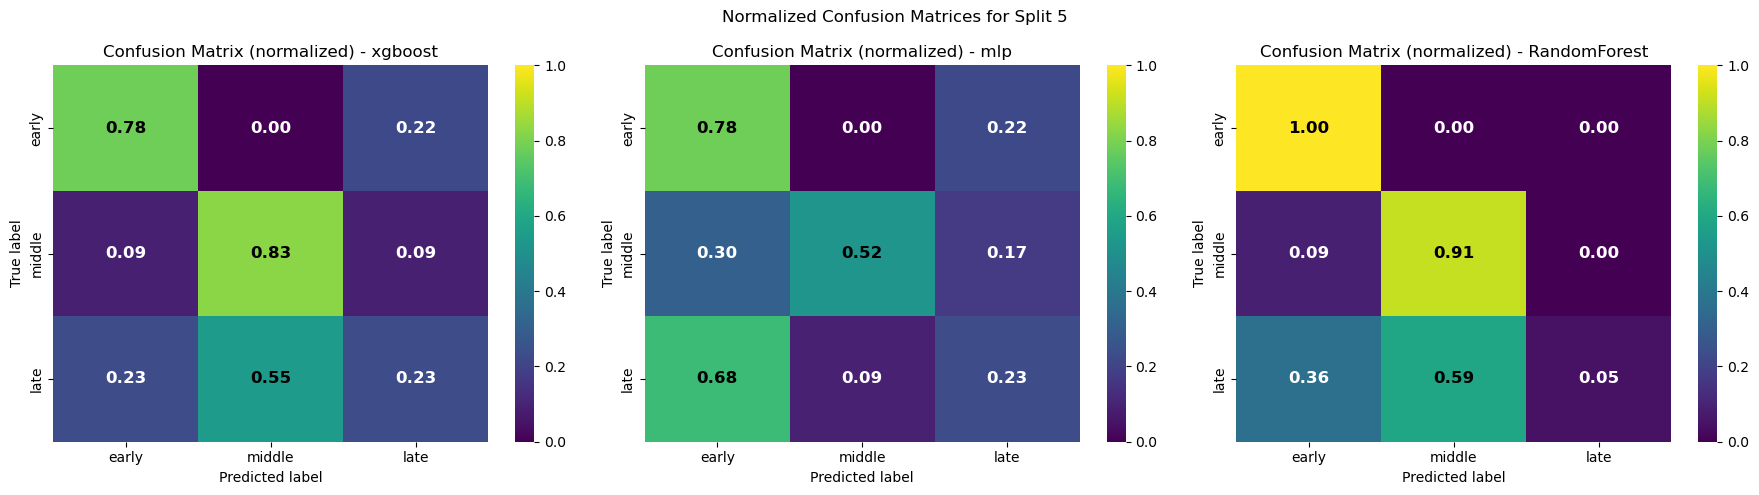

,Split,Model,Accuracy,Precision,Recall,F1
0,5,xgboost,0.574074,0.570722,0.574074,0.532597
1,5,mlp,0.444444,0.590494,0.444444,0.461137
2,5,RandomForest,0.574074,0.749427,0.574074,0.456410


=== Split 6 ===


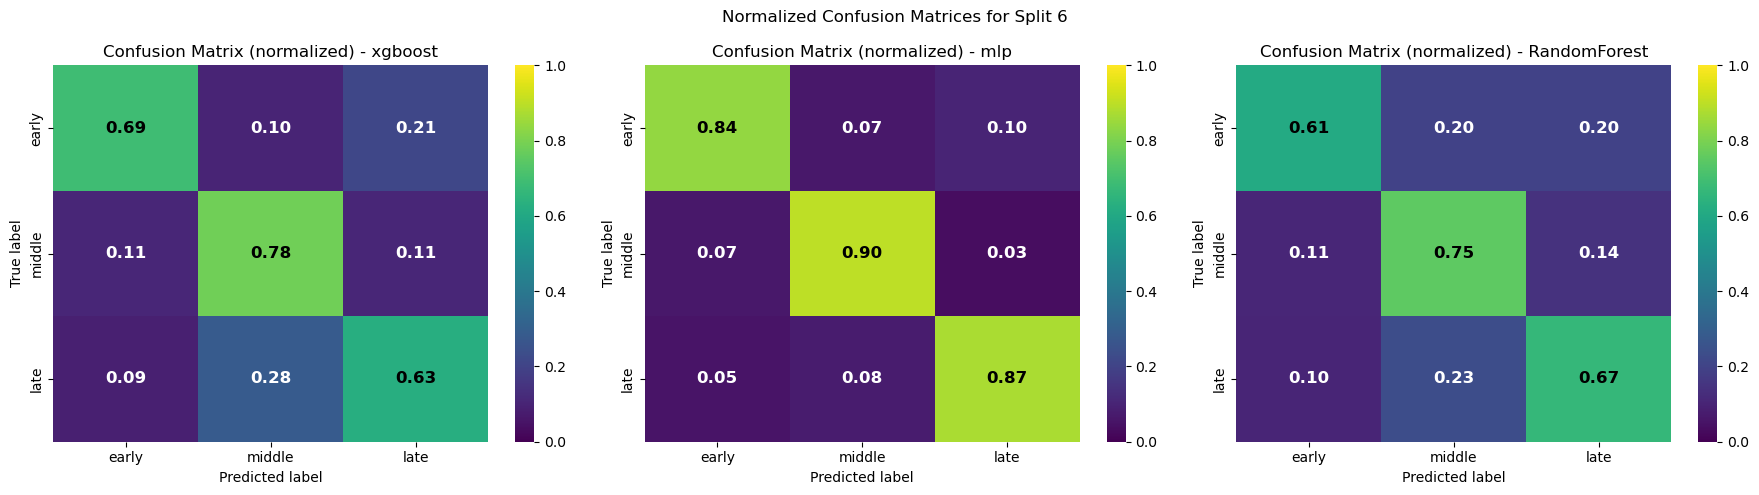

,Split,Model,Accuracy,Precision,Recall,F1
0,6,xgboost,0.705628,0.704533,0.705628,0.704156
1,6,mlp,0.874459,0.874418,0.874459,0.874416
2,6,RandomForest,0.683983,0.683259,0.683983,0.682773



Summary for XGBOOST


,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.672222,0.444444,0.439153
1,1,xgboost,0.333333,0.359253,0.333333,0.276570
2,2,xgboost,0.333333,0.617491,0.333333,0.319100
3,3,xgboost,0.350000,0.161696,0.350000,0.202821
4,4,xgboost,0.429501,0.573175,0.429501,0.408172
5,5,xgboost,0.574074,0.570722,0.574074,0.532597
6,6,xgboost,0.705628,0.704533,0.705628,0.704156



Summary for MLP


,Split,Model,Accuracy,Precision,Recall,F1
0,0,mlp,0.388889,0.518258,0.388889,0.402792
1,1,mlp,0.320675,0.358351,0.320675,0.283051
2,2,mlp,0.434028,0.573730,0.434028,0.446296
3,3,mlp,0.433333,0.549116,0.433333,0.421262
4,4,mlp,0.381779,0.552926,0.381779,0.365399
5,5,mlp,0.444444,0.590494,0.444444,0.461137
6,6,mlp,0.874459,0.874418,0.874459,0.874416



Summary for RANDOMFOREST


,Split,Model,Accuracy,Precision,Recall,F1
0,0,RandomForest,0.351852,0.123800,0.351852,0.183156
1,1,RandomForest,0.337553,0.430292,0.337553,0.278765
2,2,RandomForest,0.336806,0.561161,0.336806,0.306308
3,3,RandomForest,0.316667,0.116667,0.316667,0.170513
4,4,RandomForest,0.403471,0.556455,0.403471,0.396326
5,5,RandomForest,0.574074,0.749427,0.574074,0.456410
6,6,RandomForest,0.683983,0.683259,0.683983,0.682773


In [37]:
# Model evaluation
model_names = ["xgboost", "mlp", "RandomForest"]
class_labels = ["early", "middle", "late"]
splits = range(7)
all_results = []

for split_number in splits:
    print(f"=== Split {split_number} ===")
    fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))
    metrics_list = []

    for i, name in enumerate(model_names):
        model_dir = f"../data/{name}"
        model_file = f"model_split_{split_number}"
        data_file = f"split_{split_number}_data.pkl"
        model_path = os.path.join(model_dir, model_file)
        data_path = os.path.join(model_dir, data_file)

        try:
            # Load data 
            with open(data_path, "rb") as f:
                _, _, X_test, y_test, le, feature_cols = pickle.load(f)

            # Load model
            if name == "mlp":
                model = MLP(input_dim=X_test.shape[1], num_classes=len(le.classes_)).to(DEVICE)
                model.load_state_dict(torch.load(model_path + ".pt", map_location=DEVICE))
                model.eval()
                with torch.no_grad():
                    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
                    y_pred = model(X_tensor).argmax(dim=1).cpu().numpy()
            else:
                model = joblib.load(model_path + ".joblib")
                y_pred = model.predict(X_test)

            # Compute confusion matrix
            cm = confusion_matrix(y_test, y_pred, normalize="true")

            sns.heatmap(
                cm,
                annot=False,
                fmt=".2f",
                cmap="viridis",
                cbar=True,
                vmin=0,
                vmax=1,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axes[i]
            )

            # === Werte manuell beschriften mit Farben ===
            for y in range(cm.shape[0]):
                for x in range(cm.shape[1]):
                    val = cm[y, x]
                    color = "black" if val > 0.5 else "white"
                    axes[i].text(
                        x + 0.5,
                        y + 0.5,
                        f"{val:.2f}",
                        ha="center",
                        va="center",
                        color=color,
                        fontsize=12,
                        fontweight="bold"
                    )

            axes[i].set_title(f"Confusion Matrix (normalized) - {name}")
            axes[i].set_xlabel("Predicted label")
            axes[i].set_ylabel("True label")

            # Compute metrics
            metrics = {
                "Split": split_number,
                "Model": name,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                "F1": f1_score(y_test, y_pred, average="weighted", zero_division=0),
            }

            if not any(r["Split"] == metrics["Split"] and r["Model"] == metrics["Model"] for r in all_results):
                metrics_list.append(metrics)

        except FileNotFoundError:
            print(f"Model or data missing for {name} (Split {split_number})")
            axes[i].set_visible(False)
            continue

    plt.suptitle(f"Normalized Confusion Matrices for Split {split_number}")
    plt.tight_layout()
    plt.show()

    if metrics_list:
        df_metrics = pd.DataFrame(metrics_list)
        display(df_metrics)
        all_results.extend(metrics_list)
    else:
        print("No models evaluated for this split.")

# Summary of all results
df_all = pd.DataFrame(all_results)

for model in df_all["Model"].unique():
    print(f"\nSummary for {model.upper()}")
    df_model = df_all[df_all["Model"] == model].reset_index(drop=True)
    display(df_model)


## Further evalutation metrics

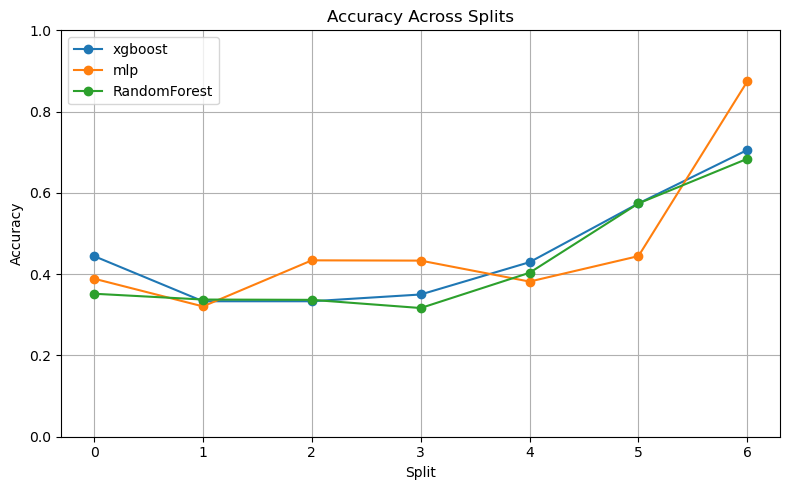

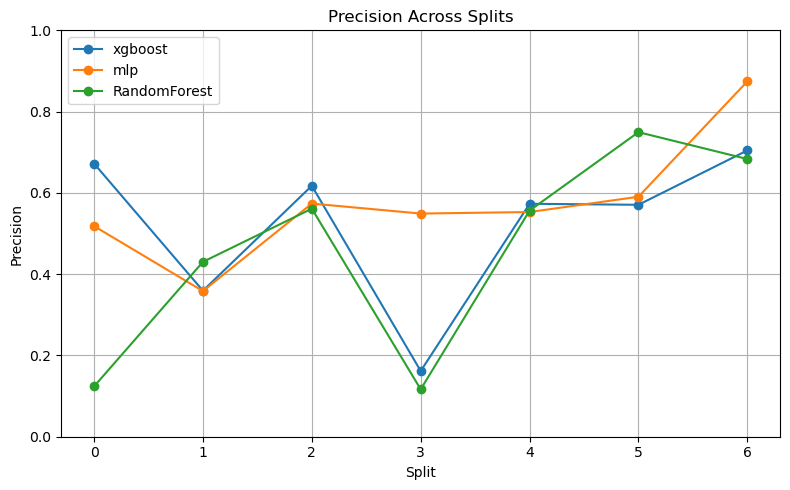

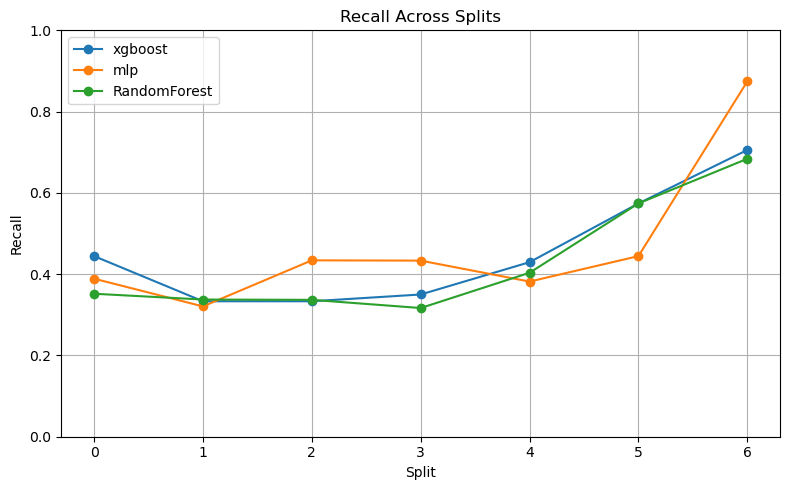

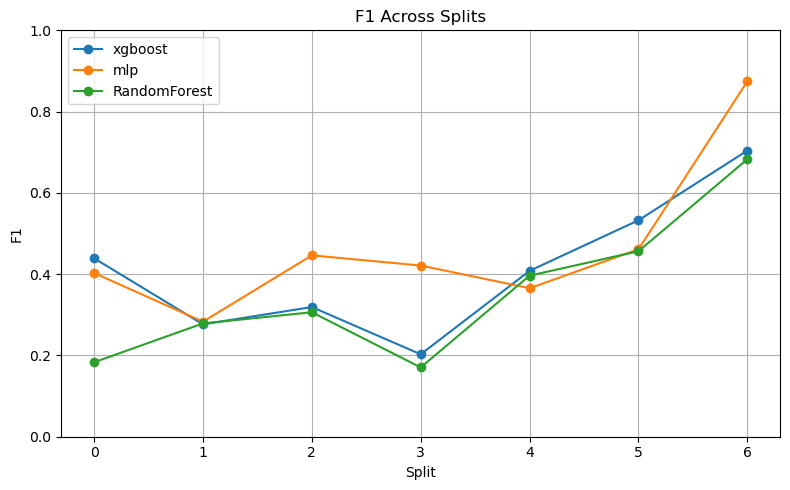

In [5]:
# Split Performance visualized

metrics = ["Accuracy", "Precision", "Recall", "F1"]

# Define color palette
color_palette = {
    "xgboost": "#1f77b4",
    "mlp": "#ff7f0e",
    "RandomForest": "#2ca02c"
}


for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in df_all["Model"].unique():
        subset = df_all[df_all["Model"] == model]
        plt.plot(subset["Split"], subset[metric], label=model, marker='o')
    plt.title(f"{metric} Across Splits")
    plt.xlabel("Split")
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

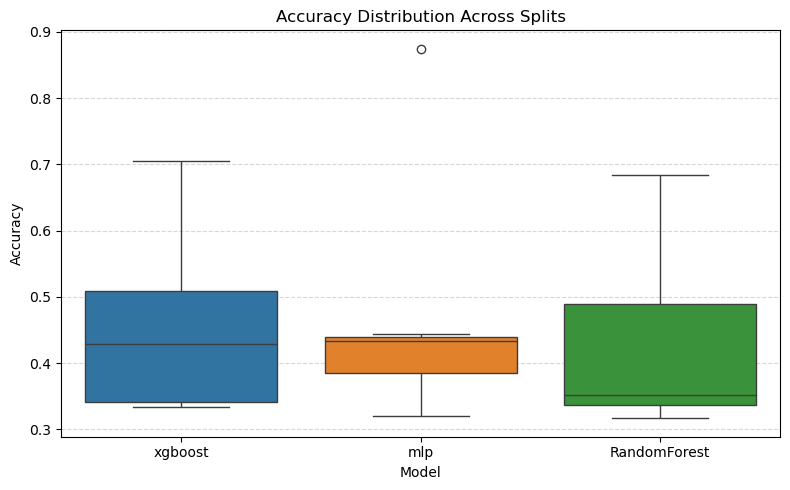

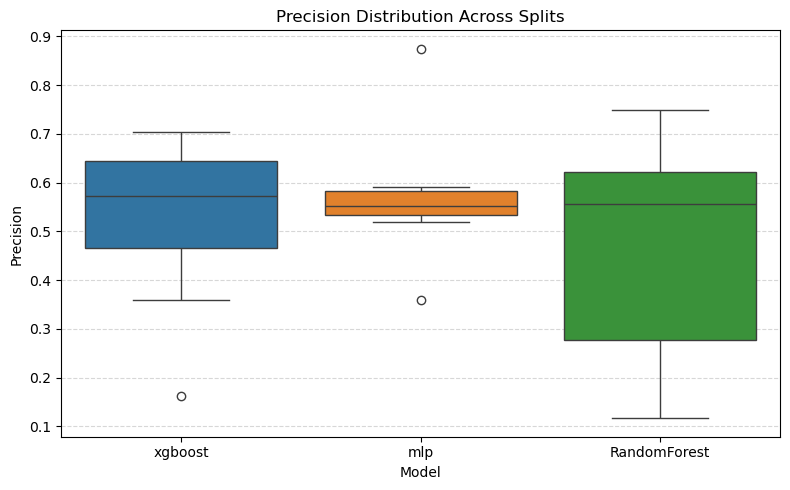

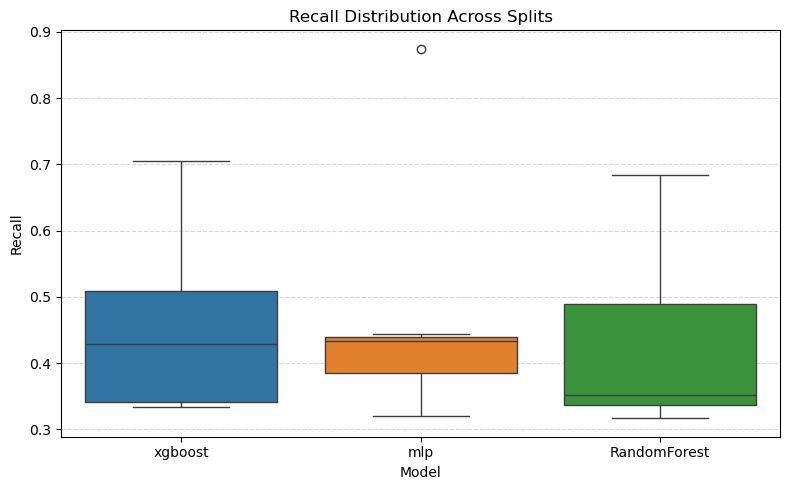

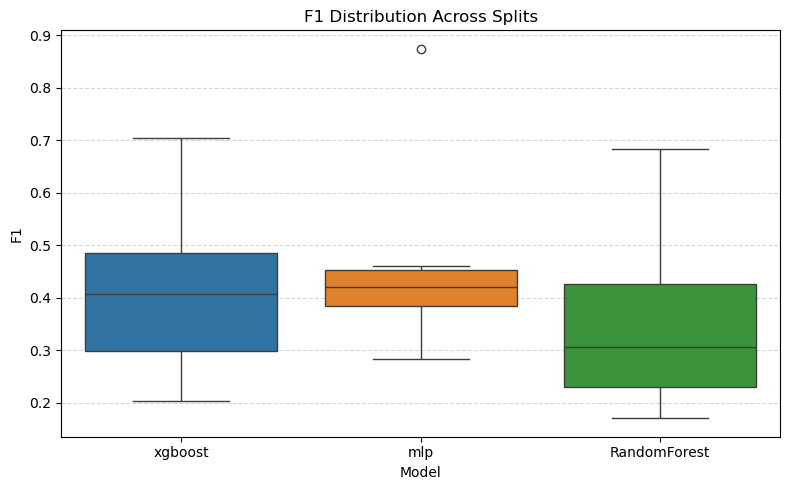

In [6]:
# Bar plot

for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        x="Model",
        y=metric,
        hue="Model",         
        data=df_all,
        palette=color_palette,
        legend=False              
    )
    plt.title(f"{metric} Distribution Across Splits")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

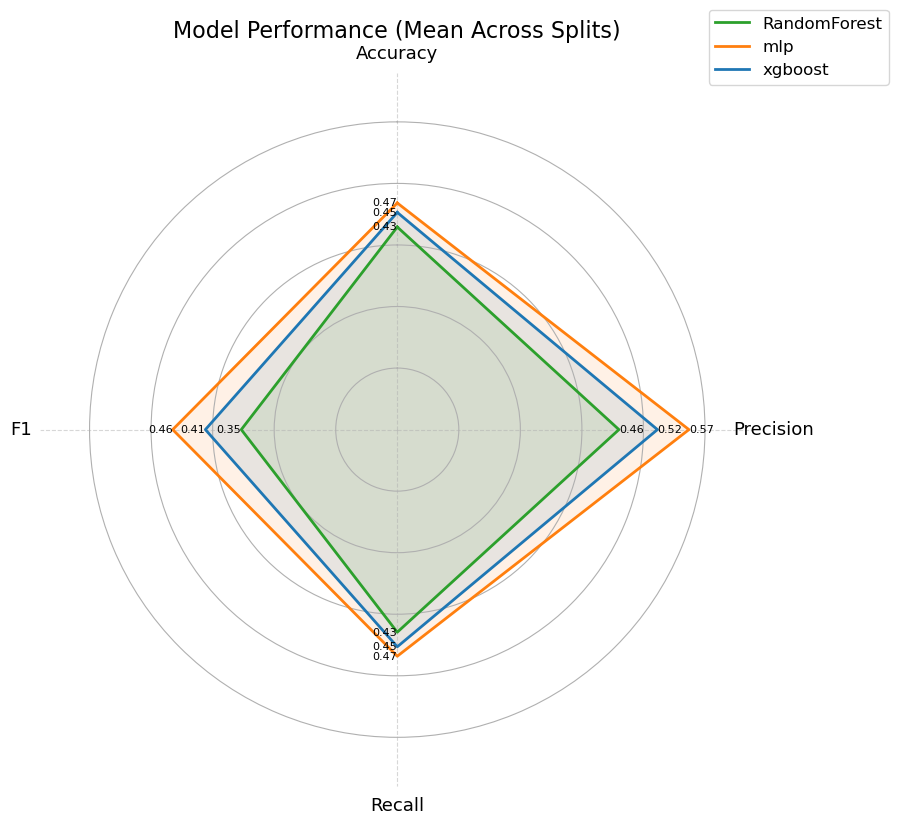

In [ ]:
# Spider plot

# ---------------- Helper: Radar-Plot Funktion ----------------
def plot_radar(metrics_df, title, color_palette, metrics=("Accuracy", "Precision", "Recall", "F1")):
    import numpy as np
    import matplotlib.pyplot as plt

    labels = list(metrics)
    num_metrics = len(labels)
    angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

    # Define individual radial label offsets per model
    label_offsets = {
        "RandomForest": -0.09,
        "mlp": 0.001,
        "xgboost": 0.01
    }

    for _, row in metrics_df.iterrows():
        model = row["Model"]
        vals = [row[m] for m in metrics]
        values = vals + [vals[0]]
        color = color_palette.get(model, None)

        ax.plot(angles, values, label=model, linewidth=2, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)

        # Use custom offset for each model
        offset = label_offsets.get(model, 0.01)  # default fallback offset

        for i in range(num_metrics):
            angle_rad = angles[i]
            value = values[i]
            ha = 'left' if 0 < angle_rad < np.pi else 'right'
            ax.text(
                angle_rad,
                value + offset,
                f"{value:.2f}",
                color="black",
                fontsize=8,
                ha=ha,
                va='center'
            )

    # Styling
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=13)
    ax.yaxis.grid(True)
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.xaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim(0.0, 1.0)

    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=12)
    plt.title(title, fontsize=16, pad=25)
    plt.tight_layout()
    plt.show()

# Radar 1: Mean across splits 
metrics = ["Accuracy", "Precision", "Recall", "F1"]
metrics_mean_all = df_all.groupby("Model")[metrics].mean().reset_index()
plot_radar(metrics_mean_all, "Model Performance (Mean Across Splits)", color_palette, metrics)

# Radar 2: Split 6
split_id = 6
df_all_local = df_all.copy()

df_all_local["Split"] = pd.to_numeric(df_all_local["Split"], errors="coerce")

df_split = df_all_local[df_all_local["Split"] == split_id]
